### Model Architecture

In [1]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

In [2]:
class EncoderEfficientNetB5(nn.Module):
    def __init__(self, pretrained=True):
        super(EncoderEfficientNetB5, self).__init__()
        # Load EfficientNet-B5
        self.encoder = EfficientNet.from_pretrained('efficientnet-b5') if pretrained else EfficientNet.from_name('efficientnet-b5')
        # Extract blocks (stages)
        self.blocks = self.encoder._blocks
        
    def forward(self, x):
        # Store features from different stages
        features = []
        x = self.encoder._conv_stem(x)  # Initial convolution
        x = self.encoder._bn0(x)       # Batch normalization
        for block in self.blocks:
            x = block(x)
            features.append(x)         # Save intermediate features
        return features


In [3]:
class DecoderFPN(nn.Module):
    def __init__(self, encoder_channels, decoder_channels):
        super(DecoderFPN, self).__init__()
        self.up_convs = nn.ModuleList()
        self.lat_convs = nn.ModuleList()

        # Build lateral and upsampling convolutions
        for in_channels in encoder_channels:
            self.lat_convs.append(nn.Conv2d(in_channels, decoder_channels, kernel_size=1))
            self.up_convs.append(nn.Conv2d(decoder_channels, decoder_channels, kernel_size=3, padding=1))
        
    def forward(self, encoder_features):
        # Start from the deepest feature and go upwards
        x = self.lat_convs[-1](encoder_features[-1])  # Lateral convolution for the deepest feature
        outputs = [x]  # Collect outputs

        # Iterate through the encoder features in reverse order
        for i in range(len(encoder_features) - 2, -1, -1):
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # Upsample
            lateral = self.lat_convs[i](encoder_features[i])  # Apply lateral convolution
            x = x + lateral  # Add lateral and upsampled feature
            x = self.up_convs[i](x)  # Apply up convolution
            outputs.append(x)
        
        return outputs[::-1]  # Reverse to match spatial resolution order


In [4]:
class EfficientNetFPN(nn.Module):
    def __init__(self, num_classes, encoder_channels, decoder_channels=256):
        super(EfficientNetFPN, self).__init__()
        self.encoder = EncoderEfficientNetB5(pretrained=True)
        self.decoder = DecoderFPN(encoder_channels, decoder_channels)
        self.final_conv = nn.Conv2d(decoder_channels, num_classes, kernel_size=1)  # Final 1x1 convolution

    def forward(self, x):
        encoder_features = self.encoder(x)
        decoder_features = self.decoder(encoder_features)
        x = decoder_features[0]  # Use the highest-resolution output
        x = self.final_conv(x)
        return x


In [24]:
# Encoder channels for EfficientNet-B5
encoder_channels = [48, 144, 240, 384, 2048]  # Output channels from each stage

# Initialize the model
model = EfficientNetFPN(num_classes=1, encoder_channels=encoder_channels) #num_classes = 2?


Loaded pretrained weights for efficientnet-b5


### Loss Functions

In [6]:
import torch
import torch.nn as nn

class BCEWithLogitsLossCustom(nn.Module):
    def __init__(self):
        super(BCEWithLogitsLossCustom, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()  # Automatically applies sigmoid

    def forward(self, inputs, targets):
        return self.bce_loss(inputs, targets)

# Example usage:
# loss_fn = BCEWithLogitsLossCustom()
# loss = loss_fn(output, target)


In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Flatten the inputs and targets
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Compute BCE loss
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        
        # Focal Loss modulation factor
        pt = torch.exp(-bce_loss)  # Probability of the true class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Example usage:
# focal_loss = FocalLoss(alpha=0.25, gamma=2)
# loss = focal_loss(output, target)


In [8]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Apply sigmoid to inputs to get probabilities
        inputs = torch.sigmoid(inputs).view(-1)  
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        union = inputs.sum() + targets.sum()

        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice_score  # To minimize the Dice Loss

# Example usage:
# dice_loss = DiceLoss()
# loss = dice_loss(output, target)


In [9]:
class DiceBCELoss(nn.Module):
    def __init__(self, alpha=0.5, smooth=1e-6):
        super(DiceBCELoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_loss = DiceLoss(smooth)

    def forward(self, inputs, targets):
        bce = self.bce_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        return bce + alpha * dice  # You can adjust the alpha weight as needed

# Example usage:
# loss_fn = DiceBCELoss(alpha=0.5)
# loss = loss_fn(output, target)


In [10]:
class DiceFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, smooth=1e-6):
        super(DiceFocalLoss, self).__init__()
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma)
        self.dice_loss = DiceLoss(smooth)

    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        return focal + dice  # You can adjust the weighting as needed

# Example usage:
# loss_fn = DiceFocalLoss(alpha=0.25, gamma=2)
# loss = loss_fn(output, target)


In [11]:
class BCEFocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(BCEFocalLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Flatten the inputs and targets
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Compute BCE loss
        bce_loss = self.bce_loss(inputs, targets)

        # Compute Focal Loss modulation factor
        pt = torch.exp(-bce_loss)  # Probability of the true class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Example usage:
# combined_loss = BCEFocalLoss(alpha=0.25, gamma=2)
# loss = combined_loss(output, target)


In [25]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import KFold
from torch.utils.data import Dataset
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss function, and optimizer
model = EfficientNetFPN(num_classes=1, encoder_channels=encoder_channels)  # Assume binary classification for kidney segmentation
model.to(device)

loss_fn = BCEWithLogitsLossCustom()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Training function
def train_model(train_loader, val_loader):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = loss_fn(outputs, masks)
        epoch_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    avg_epoch_loss = epoch_loss / len(train_loader)
    return avg_epoch_loss

# Validation function
def validate_model(val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss

# 5-Fold Cross-Validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(image_files)):
    print(f"\nTraining fold {fold+1}...")
    
    # Create subsets for training and validation
    train_image_files = [image_files[i] for i in train_idx]
    val_image_files = [image_files[i] for i in val_idx]
    train_mask_files = [mask_files[i] for i in train_idx]
    val_mask_files = [mask_files[i] for i in val_idx]

    # Create dataset and dataloaders for this fold
    train_dataset = KidneySegmentationDataset(train_image_files, train_mask_files)
    val_dataset = KidneySegmentationDataset(val_image_files, val_mask_files)

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

    # Training loop for 50 epochs
    for epoch in range(50):
        train_loss = train_model(train_loader, val_loader)
        val_loss = validate_model(val_loader)
        
        print(f"Epoch {epoch+1}/50 - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    print(f"Fold {fold+1} training completed.")

# Optionally, you can save the model after training
torch.save(model.state_dict(), "efficientnet_fpn_kidney_segmentation.pth")


Loaded pretrained weights for efficientnet-b5

Training fold 1...


RuntimeError: stack expects each tensor to be equal size, but got [1, 458, 512, 512] at entry 0 and [1, 369, 512, 512] at entry 1

In [21]:
import os
import nibabel as nib
import torch
from torch.utils.data import Dataset
import numpy as np

# Define the KidneySegmentationDataset class
class KidneySegmentationDataset(Dataset):
    def __init__(self, image_files, mask_files, transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image and mask using the correct paths
        image = nib.load(self.image_files[idx]).get_fdata()  # Load resampled image
        mask = nib.load(self.mask_files[idx]).get_fdata()    # Load resampled mask

        # Pad images and masks to match the largest depth
        max_depth = max(image.shape[0], mask.shape[0])
        
        if image.shape[0] < max_depth:
            padding = max_depth - image.shape[0]
            image = np.pad(image, ((padding, 0), (0, 0), (0, 0)), mode='constant')

        if mask.shape[0] < max_depth:
            padding = max_depth - mask.shape[0]
            mask = np.pad(mask, ((padding, 0), (0, 0), (0, 0)), mode='constant')

        # Convert to torch tensors
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask


# Define the paths for images and masks
image_folder = "D:/kits23/resampled_and_sliced_images/"
mask_folder = "D:/kits23/resampled_and_sliced_segmentation_files/"

# Generate the list of image files (assuming the filenames are correct)
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('windowed.nii.gz_resampled_and_sliced.nii.gz')]

# Generate the list of mask files corresponding to the images
mask_files = [os.path.join(mask_folder, f.replace('windowed.nii.gz_resampled_and_sliced.nii.gz', 'segmentation_resampled_and_sliced.nii.gz')) for f in os.listdir(image_folder) if f.endswith('windowed.nii.gz_resampled_and_sliced.nii.gz')]

# Create the dataset
dataset = KidneySegmentationDataset(image_files, mask_files)

# Print the case number, image shape, and mask shape in the dataset
for idx in range(len(dataset)):
    image, mask = dataset[idx]
    
    # Extract the case number from the filename
    case_number = os.path.basename(image_files[idx]).split('_')[1]
    
    print(f"Case {case_number} - Image shape: {image.shape}, Mask shape: {mask.shape}")


Case 00000 - Image shape: torch.Size([1, 306, 512, 512]), Mask shape: torch.Size([1, 306, 512, 512])
Case 00001 - Image shape: torch.Size([1, 301, 512, 512]), Mask shape: torch.Size([1, 301, 512, 512])
Case 00002 - Image shape: torch.Size([1, 261, 512, 512]), Mask shape: torch.Size([1, 261, 512, 512])
Case 00003 - Image shape: torch.Size([1, 270, 512, 512]), Mask shape: torch.Size([1, 270, 512, 512])
Case 00004 - Image shape: torch.Size([1, 256, 512, 512]), Mask shape: torch.Size([1, 256, 512, 512])
Case 00005 - Image shape: torch.Size([1, 417, 512, 512]), Mask shape: torch.Size([1, 417, 512, 512])
Case 00006 - Image shape: torch.Size([1, 471, 512, 512]), Mask shape: torch.Size([1, 471, 512, 512])
Case 00007 - Image shape: torch.Size([1, 183, 512, 512]), Mask shape: torch.Size([1, 183, 512, 512])
Case 00008 - Image shape: torch.Size([1, 681, 512, 512]), Mask shape: torch.Size([1, 681, 512, 512])
Case 00009 - Image shape: torch.Size([1, 231, 512, 512]), Mask shape: torch.Size([1, 231, 5

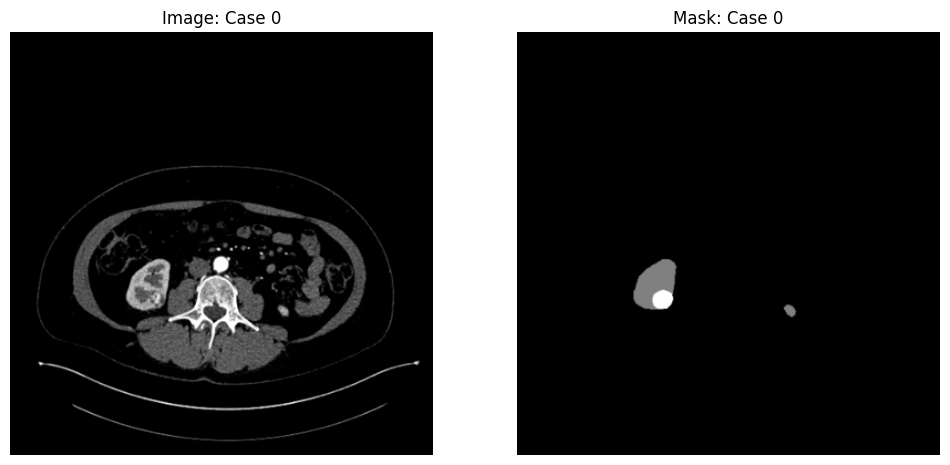

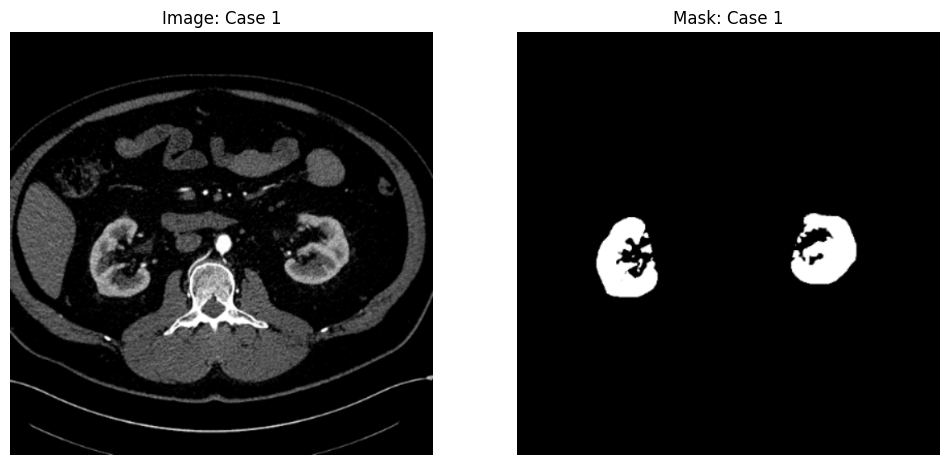

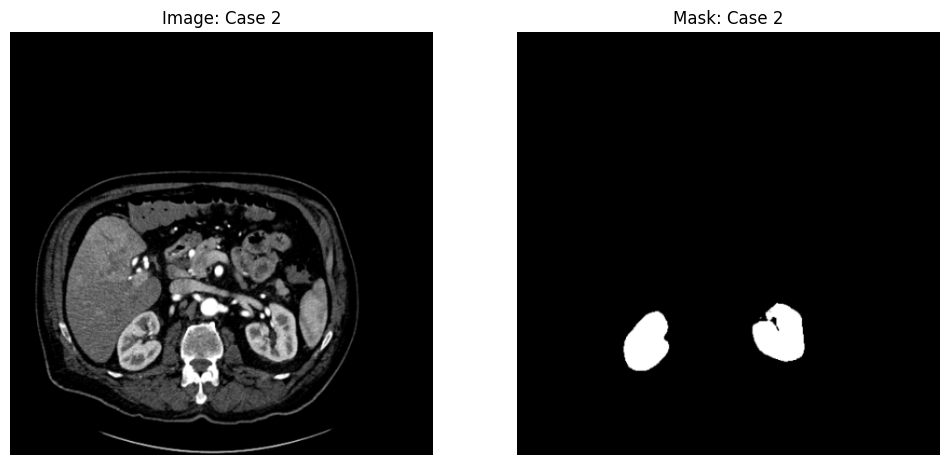

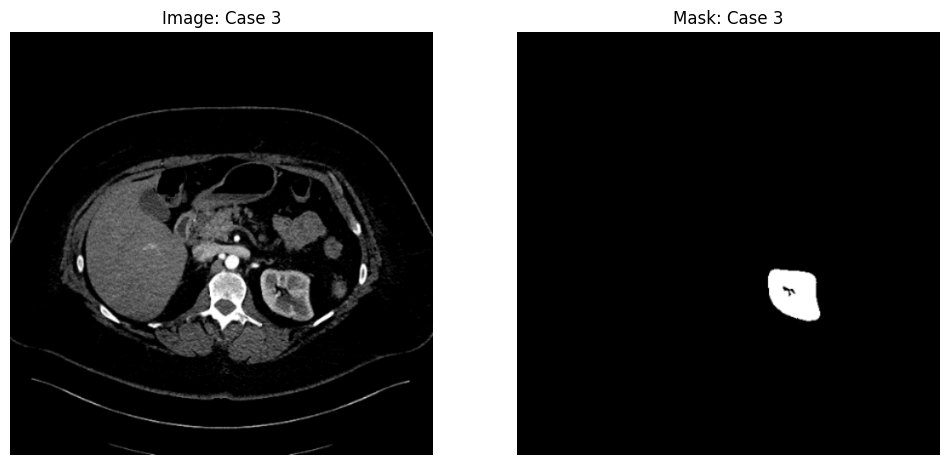

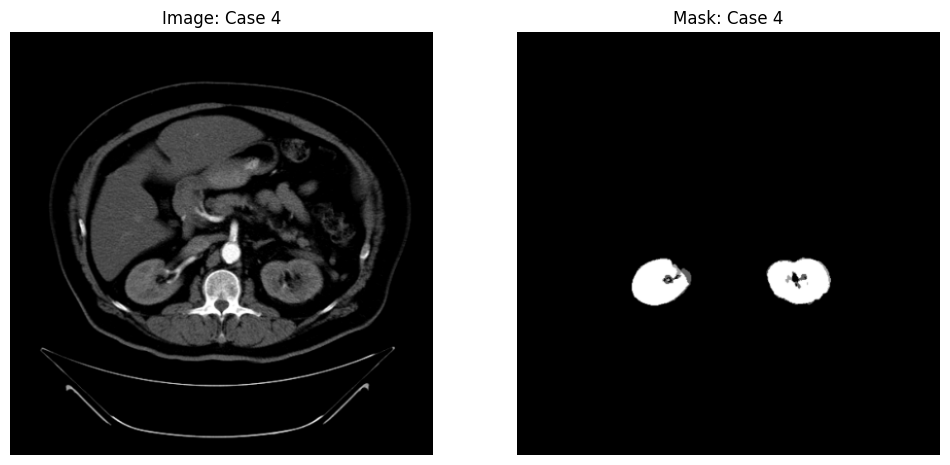

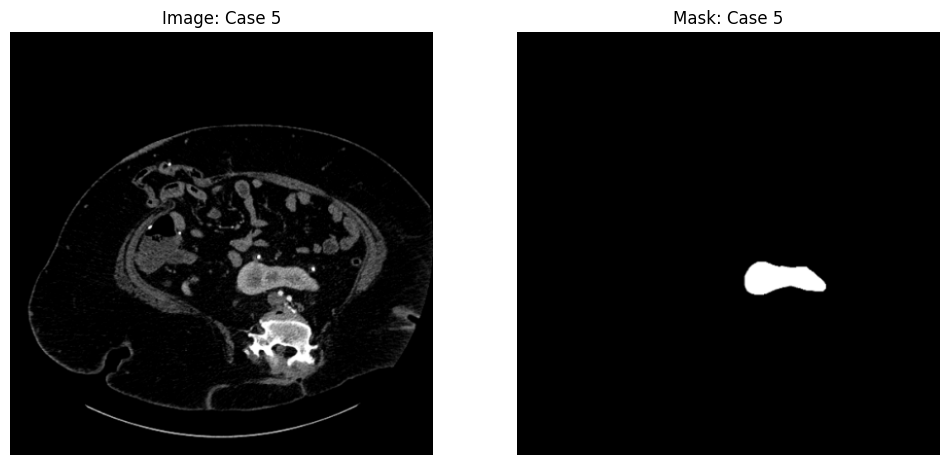

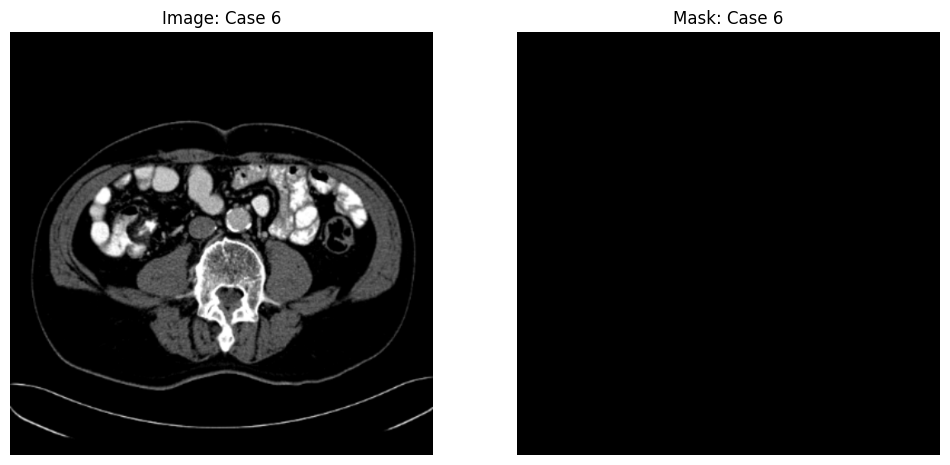

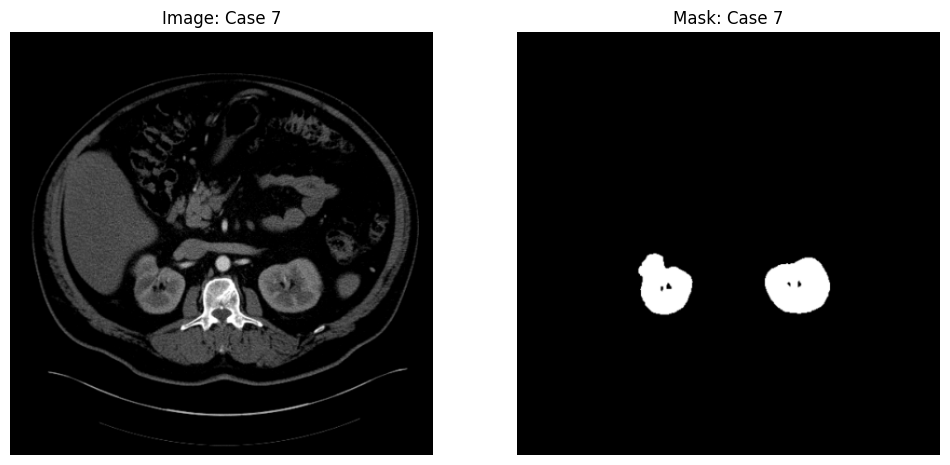

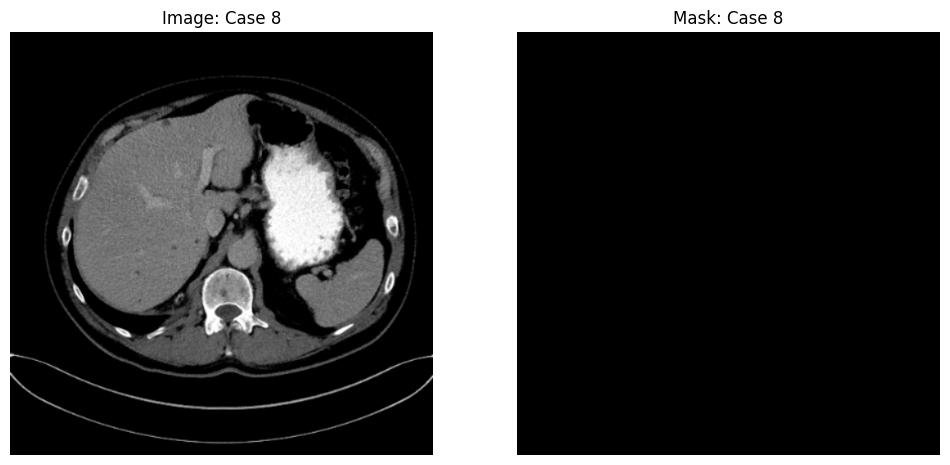

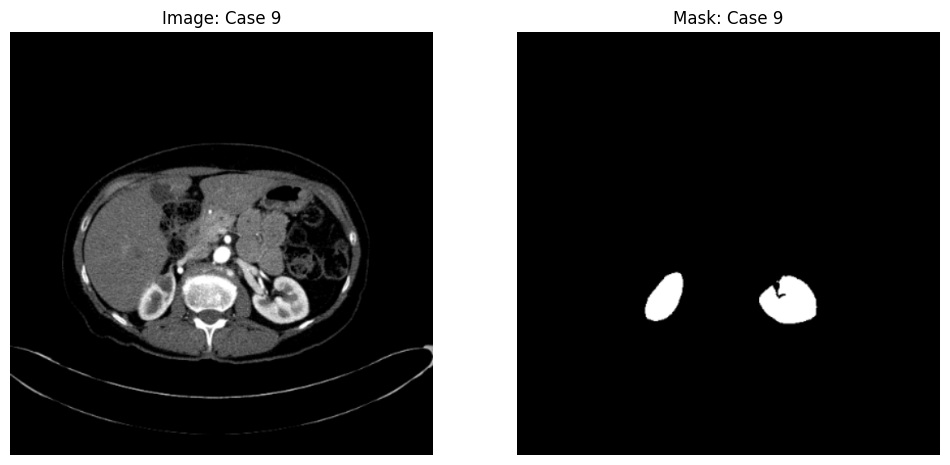

In [31]:
import nibabel as nib
import matplotlib.pyplot as plt

# Define the paths to the original images and masks
image_folder = "D:/kits23/resampled_and_sliced_images"
mask_folder = "D:/kits23/resampled_and_sliced_segmentation_files"

# Get a list of image and mask file names
image_files = [f for f in os.listdir(image_folder) if f.endswith('.nii.gz')]
mask_files = [f for f in os.listdir(mask_folder) if f.endswith('.nii.gz')]

# Display the first 10 cases (or fewer if there aren't enough cases)
n_cases_to_display = 10
for i in range(min(n_cases_to_display, len(image_files))):
    image_path = os.path.join(image_folder, image_files[i])
    mask_path = os.path.join(mask_folder, mask_files[i])

    # Load the image and mask
    image = nib.load(image_path).get_fdata()
    mask = nib.load(mask_path).get_fdata()

    # Display the first slice (or you can adjust to display any other slice)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Display image and mask
    ax1.imshow(image[image.shape[0] // 2, :, :], cmap='gray')  # Display middle slice
    ax1.set_title(f"Image: Case {i}")
    ax1.axis('off')

    ax2.imshow(mask[mask.shape[0] // 2, :, :], cmap='gray')  # Display middle slice
    ax2.set_title(f"Mask: Case {i}")
    ax2.axis('off')

    plt.show()


Tried to resize all the images to (291,512,512). The image and its ground truth are in same dimensions but, the images are of different shapes. All of them need to be in the same batch for smooth training process.

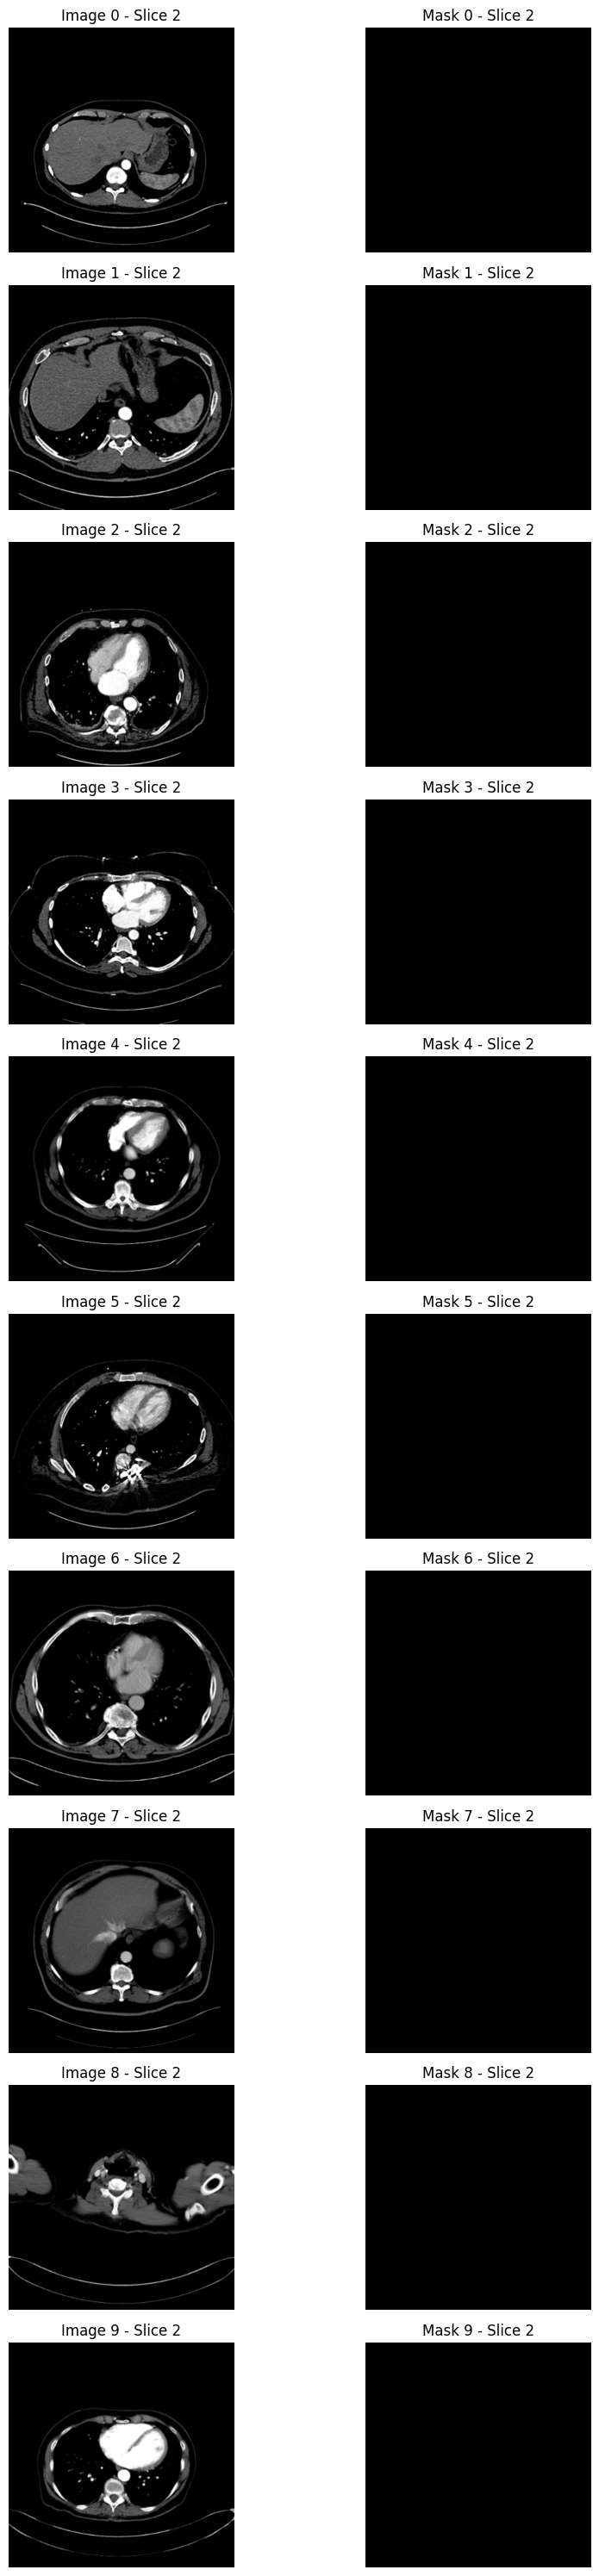

In [30]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to the image and mask folders
image_folder = "D:/kits23/resampled_and_sliced_images"
mask_folder = "D:/kits23/resampled_and_sliced_segmentation_files"

# Define the target shape for resizing (e.g., 291 slices, 512x512 pixels)
target_shape = (291, 512, 512)

# Function to resize an image to the target shape
def resize_image(image, target_shape):
    resized_image = np.resize(image, target_shape)  # Resize image to the target shape
    return resized_image

# Function to load and resize images and masks for the first N cases
def load_and_resize_first_n_cases(image_folder, mask_folder, n_cases, target_shape):
    # Get sorted list of image and mask files
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.nii.gz')])
    mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.nii.gz')])

    # Load and resize the first n cases
    resized_images = []
    resized_masks = []
    for i in range(min(n_cases, len(image_files))):
        image_path = os.path.join(image_folder, image_files[i])
        mask_path = os.path.join(mask_folder, mask_files[i])

        # Load image and mask using nibabel
        image = nib.load(image_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()

        # Resize the image and mask
        resized_image = resize_image(image, target_shape)
        resized_mask = resize_image(mask, target_shape)

        resized_images.append(resized_image)
        resized_masks.append(resized_mask)

    return resized_images, resized_masks

# Load and resize the first 10 cases
n_cases = 10
resized_images, resized_masks = load_and_resize_first_n_cases(image_folder, mask_folder, n_cases, target_shape)

# Visualize the resized images and masks for the first 3 slices of each case
fig, axes = plt.subplots(n_cases, 2, figsize=(10, 3 * n_cases))

for i in range(n_cases):
    # Show first 3 slices of the resized image and mask
    for j in range(3):
        axes[i, 0].imshow(resized_images[i][j, :, :], cmap="gray")
        axes[i, 0].set_title(f"Image {i} - Slice {j}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(resized_masks[i][j, :, :], cmap="gray")
        axes[i, 1].set_title(f"Mask {i} - Slice {j}")
        axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


Here, I tried to resize both the image and its mask (for all cases) to (291,512,512).

In [34]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to the image and mask folders
image_folder = "D:/kits23/resampled_and_sliced_images"
mask_folder = "D:/kits23/resampled_and_sliced_segmentation_files"

# Define the target shape for resizing (e.g., 291 slices, 512x512 pixels)
target_shape = (291, 512, 512)

# Function to resize an image to the target shape
def resize_image(image, target_shape):
    resized_image = np.resize(image, target_shape)  # Resize image to the target shape
    return resized_image

# Function to load and resize images and masks for the first N cases
def load_and_resize_first_n_cases(image_folder, mask_folder, n_cases, target_shape):
    # Get sorted list of image and mask files
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.nii.gz')])
    mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.nii.gz')])

    # Load and resize the first n cases
    resized_images = []
    resized_masks = []
    for i in range(min(n_cases, len(image_files))):
        image_path = os.path.join(image_folder, image_files[i])
        mask_path = os.path.join(mask_folder, mask_files[i])

        # Load image and mask using nibabel
        image = nib.load(image_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()

        # Resize the image and mask
        resized_image = resize_image(image, target_shape)
        resized_mask = resize_image(mask, target_shape)

        resized_images.append(resized_image)
        resized_masks.append(resized_mask)

    return resized_images, resized_masks

# Load and resize the first 10 cases
n_cases = 10
resized_images, resized_masks = load_and_resize_first_n_cases(image_folder, mask_folder, n_cases, target_shape)

# Visualize the resized images and masks for the first 3 slices of each case
fig, axes = plt.subplots(n_cases, 2, figsize=(10, 3 * n_cases))

for i in range(n_cases):
    # Show first 3 slices of the resized image and mask
    for j in range(3):
        axes[i, 0].imshow(resized_images[i][j, :, :], cmap="gray")
        axes[i, 0].set_title(f"Image {i} - Slice {j}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(resized_masks[i][j, :, :], cmap="gray")
        axes[i, 1].set_title(f"Mask {i} - Slice {j}")
        axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


MemoryError: 

But, maybe we should resize them to size//2 or something like that? Refer the base paper for the resize dimensions they used. After successful resizing, try the below code for training...

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from tqdm import tqdm
import os
import numpy as np
import nibabel as nib
from torchvision import transforms
from torchvision.transforms import ToTensor
from PIL import Image

# Custom Dataset class
class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, mask_folder, transform=None):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.nii.gz')])
        self.mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.nii.gz')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder, self.image_files[idx])
        mask_path = os.path.join(self.mask_folder, self.mask_files[idx])

        # Load the image and mask using nibabel
        image = nib.load(image_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()

        # Convert to a suitable format if necessary, e.g., normalize, resize, etc.
        # Here we can add transformation logic if needed
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Custom BCE Loss function (not using BCEWithLogitsLoss)
class BCEWithLogitsLossCustom(nn.Module):
    def __init__(self):
        super(BCEWithLogitsLossCustom, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()  # Automatically applies sigmoid

    def forward(self, inputs, targets):
        return self.bce_loss(inputs, targets)

# Model definition
class EfficientNetFPN(nn.Module):
    def __init__(self, num_classes, encoder_channels, decoder_channels=256):
        super(EfficientNetFPN, self).__init__()
        self.encoder = EncoderEfficientNetB5(pretrained=True)  # Define the encoder
        self.decoder = DecoderFPN(encoder_channels, decoder_channels)  # Define the decoder
        self.final_conv = nn.Conv2d(decoder_channels, num_classes, kernel_size=1)  # Final 1x1 convolution

    def forward(self, x):
        encoder_features = self.encoder(x)
        decoder_features = self.decoder(encoder_features)
        x = decoder_features[0]  # Use the highest-resolution output
        x = self.final_conv(x)
        return x

# Dice Score function
def dice_score(predictions, targets, threshold=0.5):
    predictions = predictions > threshold
    intersection = torch.sum(predictions * targets)
    return (2. * intersection + 1e-6) / (torch.sum(predictions) + torch.sum(targets) + 1e-6)

# Define training loop
def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, num_epochs=50):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm(train_loader, leave=True, desc=f"Epoch {epoch + 1}/{num_epochs}")
        for images, masks in loop:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)  # Forward pass
            loss = loss_fn(outputs, masks)  # Compute loss
            loss.backward()  # Backpropagate gradients
            optimizer.step()  # Update weights
            
            running_loss += loss.item()  # Accumulate loss

            loop.set_postfix(loss=running_loss / len(train_loader))

        # Validation after each epoch
        model.eval()
        avg_dice = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                avg_dice += dice_score(outputs, masks).item()

        avg_dice /= len(val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs} - Validation Dice score: {avg_dice:.4f}")

    print("Training complete")

# Cross-validation loop
def cross_validate(model_class, dataset, num_folds=5, num_epochs=50, batch_size=2, learning_rate=0.001):
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_fn = BCEWithLogitsLossCustom()
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Training fold {fold + 1}/{num_folds}")

        # Prepare datasets and dataloaders for this fold
        train_subdataset = torch.utils.data.Subset(dataset, train_idx)
        val_subdataset = torch.utils.data.Subset(dataset, val_idx)
        train_loader = DataLoader(train_subdataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subdataset, batch_size=batch_size, shuffle=False)

        # Model initialization
        model = model_class(num_classes=1, encoder_channels=[32, 64, 128, 256, 512])  # Adjust channels as per your architecture
        model = model.to(device)

        # Optimizer
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Train the model for this fold
        train_model(model, train_loader, val_loader, optimizer, loss_fn, device, num_epochs=num_epochs)

        # Save predictions as PNG
        model.eval()
        os.makedirs(f"predictions_fold_{fold + 1}", exist_ok=True)  # Create folder to save predictions
        with torch.no_grad():
            for i, (images, masks) in enumerate(val_loader):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                pred = outputs.squeeze().cpu().numpy()
                pred = np.where(pred > 0.5, 1, 0)  # Threshold predictions to binary mask
                pred_image = Image.fromarray(pred[0].astype(np.uint8) * 255)  # Convert to PIL image and scale
                pred_image.save(f"predictions_fold_{fold + 1}/pred_{i}.png")

# Main execution
if __name__ == "__main__":
    # Define the dataset
    dataset = Dataset(image_folder="D:/kits23/resampled_and_sliced_images",
                      mask_folder="D:/kits23/resampled_and_sliced_segmentation_files")

    # Cross-validation with EfficientNet FPN
    cross_validate(EfficientNetFPN, dataset, num_folds=5, num_epochs=50, batch_size=2, learning_rate=0.001)


Training fold 1/5
Loaded pretrained weights for efficientnet-b5


Epoch 1/50:   0%|          | 0/196 [00:05<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [291, 512, 512] at entry 0 and [220, 512, 512] at entry 1